In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/L4_datos.zip" -d "/content/L4_datos"

Archive:  /content/drive/MyDrive/L4_datos.zip
replace /content/L4_datos/data/Comunas/comunas.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Primero voy a cargar todos los archivos y explorarlos para ver como son

In [3]:
import geopandas as gpd
import pandas as pd

#Cargar archivos geoespaciales de accidentes
acc_bici       = gpd.read_file("/content/L4_datos/data/Accidentes/Bicicletas_2019.geojson")
acc_atrop      = gpd.read_file("/content/L4_datos/data/Accidentes/Atropellos_2020.geojson")
acc_moto       = gpd.read_file("/content/L4_datos/data/Accidentes/Motocicletas_2019.geojson")
acc_puntos     = gpd.read_file("/content/L4_datos/data/Accidentes/Puntos_criticos_2019.geojson")

#Cargar archivos geoespaciales principales
comunas        = gpd.read_file("/content/L4_datos/data/Comunas/comunas.shp")
areas_urbanas  = gpd.read_file("/content/L4_datos/data/Areas Urbanas/areas_urbanas.shp")
distritos      = gpd.read_file("/content/L4_datos/data/Distritos Censales/Distritos Censales RM.shp")
metro_lineas   = gpd.read_file("/content/L4_datos/data/Metro 2020/Lineas_2020/Lineas_2020.shp")
metro_estaciones = gpd.read_file("/content/L4_datos/data/Metro 2020/Estaciones_2020/Estaciones_2020.shp")

1 a)

vamos a enfocarnos en las areas urbanas en Santiago

In [4]:
areas_urbanas.head(4)

,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry
0,Chiguayante,Ciudad,29855.998337,1.038076e+07,"POLYGON ((140044.634 5911024.284, 140051.361 5..."
1,Lota,Ciudad,14233.349738,5.262642e+06,"POLYGON ((131359.666 5889462.902, 131475.343 5..."
2,Coronel,Ciudad,41577.791832,1.551685e+07,"POLYGON ((127278.44 5896965.436, 127411.675 58..."
3,San Rosendo,Ciudad,6499.369423,1.534402e+06,"POLYGON ((168583.83 5870293.97, 168725.579 587..."


In [5]:
# Proyectar a UTM19S para cálculos espaciales
areas_urbanas = areas_urbanas.to_crs(epsg=32719)

# Filtrar solo Santiago urbano
santiago_urbano = areas_urbanas[areas_urbanas['NOMBRE'] == 'Santiago']

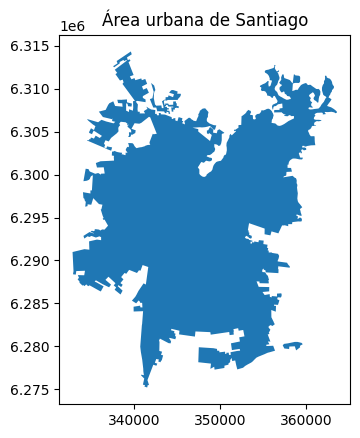

In [6]:
import matplotlib.pyplot as plt

# Visualizar Santiago urbano
santiago_urbano.plot()
plt.title("Área urbana de Santiago")
plt.show()

In [7]:
comunas_santiago = gpd.overlay(comunas, santiago_urbano, how='intersection')

/tmp/ipython-input-4030130428.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:32719

  comunas_santiago = gpd.overlay(comunas, santiago_urbano, how='intersection')


In [8]:
# Unir todos los accidentes en un solo GeoDataFrame
accidentes = pd.concat([acc_bici, acc_atrop, acc_moto, acc_puntos], ignore_index=True)
print("Cantidad total de accidentes cargados:", len(accidentes))

Cantidad total de accidentes cargados: 4938


In [9]:
# Proyectar comunas y accidentes a UTM19S (mismo CRS que Santiago urbano)
comunas = comunas.to_crs(epsg=32719)
accidentes = accidentes.to_crs(epsg=32719)

In [10]:
print(comunas.columns)
print(accidentes.columns)

Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry'],
      dtype='object')
Index(['FID', 'Ano', 'Codregion', 'Region', 'Comuna', 'Zona', 'Calle1',
       'Calle2', 'Numero', 'lat', 'lng', 'Claseaccid', 'Cód_Comun', 'Cód_Zona',
       'Zona_1', 'Cód_Ubica', 'Ubicación', 'Cód_Calle', 'Intersecci',
       'Pistas_de_', 'Pistas_de1', 'Cód_Calza', 'Calzada', 'Cód__Tipo',
       'Tipo_Calza', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves',
       'Accidentes', 'geometry', 'DIR_GEOCOD', 'LAT', 'LNG', 'Año', 'Cód_Regi',
       'Región', 'Calle_Uno', 'Calle_Dos', 'Número', 'Direccion', 'Atropellos',
       'Tipo__CONA'],
      dtype='object')


In [13]:
from unidecode import unidecode
# Normalizamos los nombres de comunas para evitar errores de tildes o Ñ
comunas['Comuna_norm'] = comunas['Comuna'].apply(lambda x: unidecode(x).upper())
accidentes['Comuna_norm'] = accidentes['Comuna'].apply(lambda x: unidecode(str(x)).upper())

# Contamos la cantidad de accidentes por comuna
accidentes_por_comuna = accidentes.groupby('Comuna_norm').size().reset_index(name='total_accidentes')
print(accidentes_por_comuna.head())

       Comuna_norm  total_accidentes
0          A'UA'OA               210
1             BUIN                13
2  CALERA DE TANGO                 3
3        CERRILLOS               118
4      CERRO NAVIA                55


In [14]:
comunas_accidentes = comunas.merge(accidentes_por_comuna, on='Comuna_norm', how='left')
comunas_accidentes['total_accidentes'] = comunas_accidentes['total_accidentes'].fillna(0)  # Reemplazamos NaN con 0

nivel_accidentes
Baja     318
Media     23
Alta       5
Name: count, dtype: int64


/tmp/ipython-input-2136877467.py:25: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  comunas_urbanas.plot(ax=ax, column='nivel_accidentes', color=comunas_urbanas['nivel_accidentes'].map(colors), legend=True)


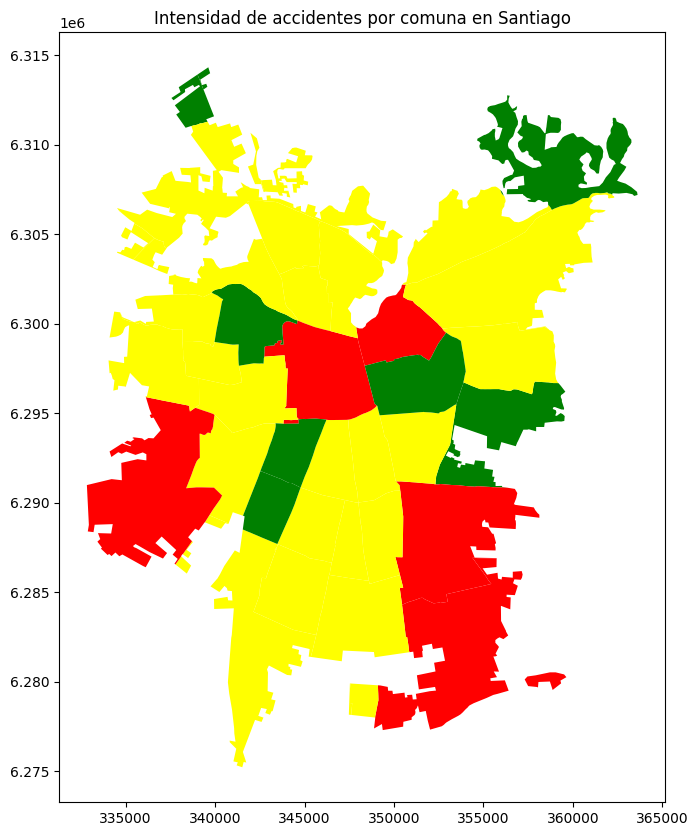

In [15]:
def nivel_accidentes(fila):
    """Clasifica la intensidad de accidentes según percentiles."""
    if fila['total_accidentes'] <= 50:   # Baja intensidad
        return 'Baja'
    elif fila['total_accidentes'] <= 200: # Media intensidad
        return 'Media'
    else:                                # Alta intensidad
        return 'Alta'

comunas_accidentes['nivel_accidentes'] = comunas_accidentes.apply(nivel_accidentes, axis=1)
print(comunas_accidentes['nivel_accidentes'].value_counts())


colors = {
    'Baja': 'green',
    'Media': 'yellow',
    'Alta': 'red'
}

#Intersección con área urbana y plot
comunas_urbanas = gpd.overlay(comunas_accidentes, santiago_urbano, how='intersection')

#Grafica
fig, ax = plt.subplots(figsize=(10,10))
comunas_urbanas.plot(ax=ax, column='nivel_accidentes', color=comunas_urbanas['nivel_accidentes'].map(colors), legend=True)
ax.set_title("Intensidad de accidentes por comuna en Santiago")
plt.show()